In [13]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../01_preprocess/preprocessed.csv')
# Calculate the percentile brackets
df['percentile bracket'] = pd.qcut(df['time'], q=10, labels=False, duplicates='drop') + 1

df.drop(['cycle', 'instr', 'LLC_miss','CPU','L1_miss', 'br_miss', 'scale', 'counted_final_key_count', 'GHz', 'time', 'task', 'IPC'], axis=1, inplace=True)
df.head()

,config_name,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,...,ycsb_range_len,ycsb_zipf,nodeCount_Leaf,nodeCount_Inner,nodeCount_Dense,nodeCount_Hash,nodeCount_Head4,nodeCount_Head8,nodeCount_Dense2,percentile bracket
0,hash,16,1,0,0,0,1,0,0,1,...,100,1.133614,0,846,0,121433,0,0,0,5
1,hash,16,1,0,0,0,1,0,0,1,...,100,1.133614,0,846,0,121433,0,0,0,4
2,dense3,16,1,1,0,1,0,0,0,1,...,100,0.316120,38703,270,0,0,0,0,0,3
3,dense3,16,1,1,0,1,0,0,0,1,...,100,0.316120,38703,270,0,0,0,0,0,8
4,hints,16,1,0,0,0,0,0,0,1,...,100,0.666485,27850,742,0,0,0,0,0,6


In [14]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 35
Number of columns after one-hot: 40


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('percentile bracket', axis=1), df['percentile bracket'], test_size=0.2, random_state=42)

# Create an instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier(max_depth=5)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predict the output variable for the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.6913222141648537
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.90      0.90       822
           2       0.77      0.61      0.68       816
           3       0.70      0.65      0.67       832
           4       0.79      0.59      0.67       830
           5       0.76      0.77      0.77       825
           6       0.78      0.76      0.77       812
           7       0.60      0.52      0.56       827
           8       0.52      0.51      0.52       820
           9       0.52      0.60      0.56       851
          10       0.66      1.00      0.80       839

    accuracy                           0.69      8274
   macro avg       0.70      0.69      0.69      8274
weighted avg       0.70      0.69      0.69      8274



In [22]:
from sklearn import tree
decision_tree = rf_classifier.estimators_[9]
df['percentile bracket'] = df['percentile bracket'].astype(str)+"0%"
text_representation = tree.export_graphviz(decision_tree, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True, out_file="tree99.dot")


XAI - using the SHAP library
https://shap.readthedocs.io/en/latest/

In [23]:
input_data=pd.read_csv('../01_preprocess/shap_raw.csv')
# Identify non-numeric columns
non_numeric_columns = input_data.select_dtypes(['object']).columns

print("Number of columns:", input_data.shape[1])

# Apply one-hot encoding to non-numeric columns
input_data = pd.get_dummies(input_data, columns=non_numeric_columns)

print("Number of columns after one-hot:", input_data.shape[1])

Number of columns: 34
Number of columns after one-hot: 39


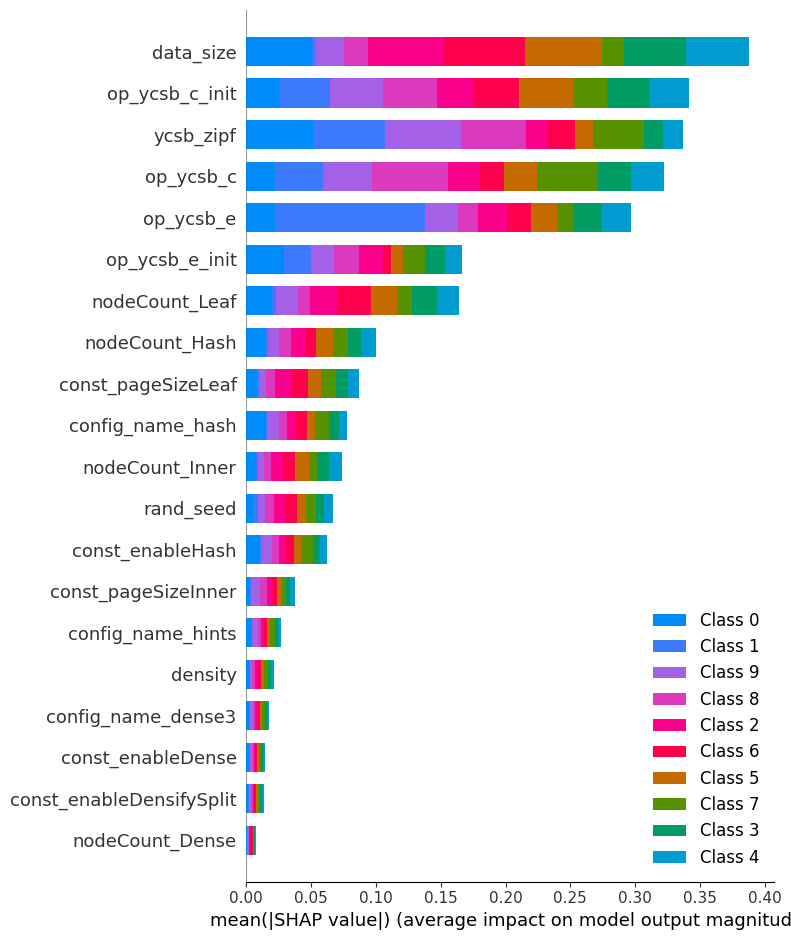

In [24]:
import shap
explainer = shap.Explainer(rf_classifier)

shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, input_data)

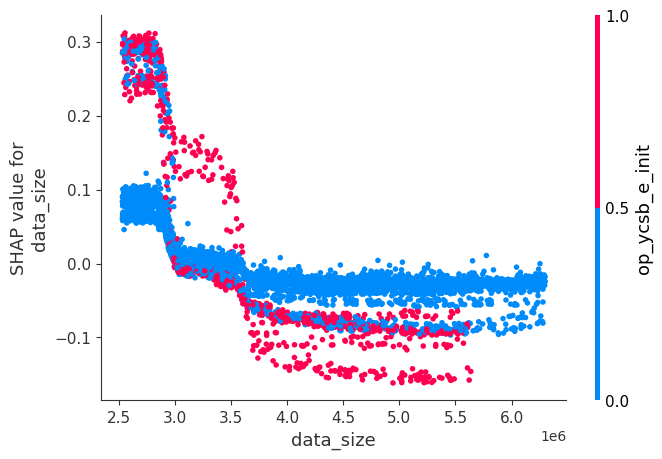

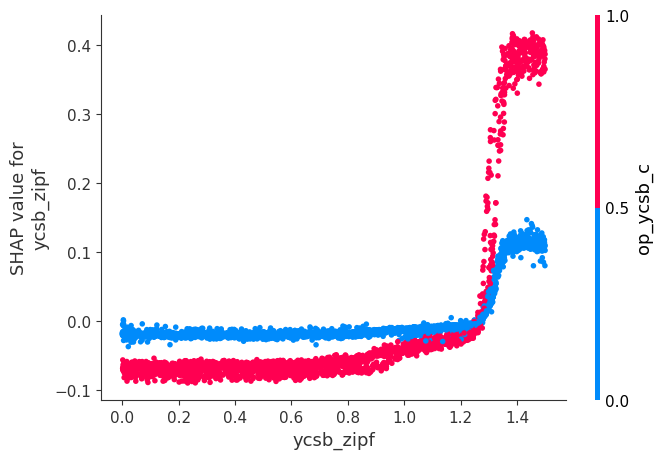

In [27]:
shap.dependence_plot("data_size", shap_values[0], input_data)

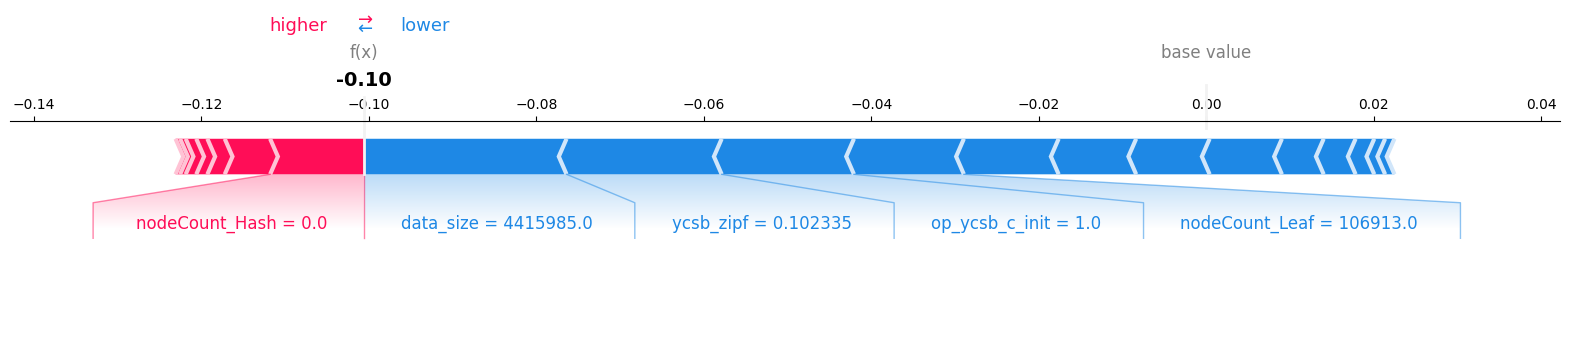

In [38]:
# initialize JS visualization code
import matplotlib
shap.initjs()
shap.force_plot(0, shap_values[0][0], input_data.iloc[0],matplotlib=matplotlib)
#THIS IS USELESS


In [11]:
X_train.replace({False: 0, True: 1}, inplace=True)


In [12]:
from interpret.blackbox import LimeTabular
from interpret import show

lime = LimeTabular(rf_classifier, X_train, random_state=42)
show(lime.explain_local(X_test[:5], y_test[:5]), 0)

Exception: multiclass LIME not supported